In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython import display
from thermistor_tools import detect_base2

# Load dataframe and do some preprocessing

### Thermistor spacing is 2 cm

In [2]:
data = 'SERF_met_data/SERF_TC_S_2020_02_18_15_40_44.dat'

dat = pd.read_csv(data,
                  skiprows=1)

dat.columns = [f'{col_name}, {dat.iloc[0][col_name]}' for col_name in dat.columns]

dat.drop([0,1] ,inplace=True)

dat.head()
                  
dat['dt'] = pd.to_datetime(dat['TIMESTAMP, TS'])

dat.set_index('dt',inplace=True)


start_date = datetime.datetime(year=2020,month=1,day=21)
end_date = datetime.datetime(year=2020,month=2,day=20)
dat = dat.loc[(dat.index > start_date) & (dat.index < end_date)]

dat.head()

,"TIMESTAMP, TS","RECORD, RN","year, nan","month, nan","domonth, nan","doy, nan","hour, nan","minute, nan","seconds, nan","Cr1000T, Deg C",...,"Temp_S(23), Deg C","Temp_S(24), Deg C","Temp_S(25), Deg C","Temp_S(26), Deg C","Temp_S(27), Deg C","Temp_S(28), Deg C","Temp_S(29), Deg C","Temp_S(30), Deg C","Temp_S(31), Deg C","Temp_S(32), Deg C"
dt,,,,,,,,,,,,,,,,,,,,,
2020-01-21 00:10:00,2020-01-21 00:10:00,6131,2020,1,21,21,0,10,0,-17.62,...,-1.387,-1.378,-1.378,-1.378,-1.378,-1.378,-1.378,-1.36,-1.36,-1.378
2020-01-21 00:20:00,2020-01-21 00:20:00,6132,2020,1,21,21,0,20,0,-17.62,...,-1.396,-1.396,-1.378,-1.378,-1.369,-1.361,-1.361,-1.361,-1.361,-1.361
2020-01-21 00:30:00,2020-01-21 00:30:00,6133,2020,1,21,21,0,30,0,-17.62,...,-1.387,-1.395,-1.387,-1.378,-1.378,-1.369,-1.378,-1.378,-1.378,-1.378
2020-01-21 00:40:00,2020-01-21 00:40:00,6134,2020,1,21,21,0,40,0,-17.62,...,-1.395,-1.395,-1.378,-1.378,-1.378,-1.378,-1.378,-1.378,-1.378,-1.378
2020-01-21 00:50:00,2020-01-21 00:50:00,6135,2020,1,21,21,0,50,0,-17.59,...,-1.372,-1.372,-1.363,-1.354,-1.354,-1.354,-1.354,-1.354,-1.354,-1.354


# Now turn the dataframe into a numpy array

In [3]:
sensor_cols = list([f'Temp_S({i}), Deg C' for i in range(1,32)])

string_data = dat[sensor_cols]

string_data.head()

array = string_data.to_numpy(dtype=float)

array = np.transpose(array)

array.shape

(31, 4319)

# Make a plot of the numpy array

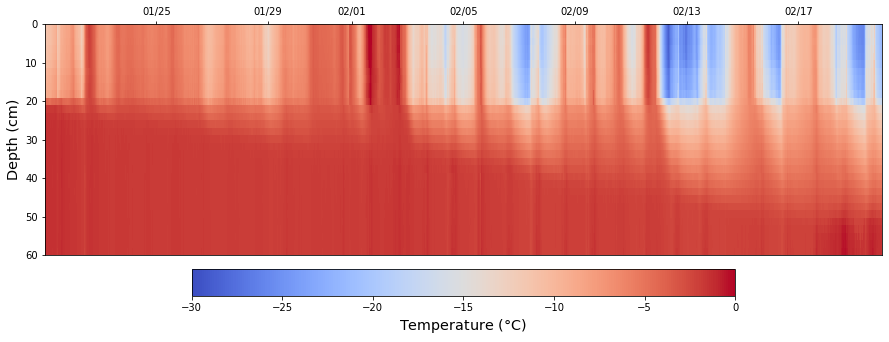

In [4]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))

# Set up y axis

y_lims = (30,0)
ax.set_yticks(range(0,31,5))
ax.set_yticklabels(range(0,61,10))
ax.set_ylabel('Depth (cm)', fontsize='x-large')

# Set date ticks

x_lims = mdates.date2num([dat.index[0], dat.index[-1]])
ax.xaxis_date()
date_format = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# ax.set_xlabel('Date', fontsize='x-large')


# Set up plot area

extent = [x_lims[0],
          x_lims[1],
          y_lims[0],
          y_lims[1],
         ]


# Make the plot

imshow = ax.imshow(array, extent = extent, aspect='auto', cmap='coolwarm', vmin = -30, vmax = 0)

# Colorbar

cb = fig.colorbar(imshow,orientation='horizontal',fraction=0.1,pad=0.05)
cb.set_label(label = r'Temperature ($\degree$C)', fontsize='x-large')

# Visualise

plt.show()

# The above plot isn't *that* useful, it's tough to to see where the upper and lower surfaces of the ice are.

# What we really need to be looking at is the *gradient* in the temperature, not the temperature itself. 

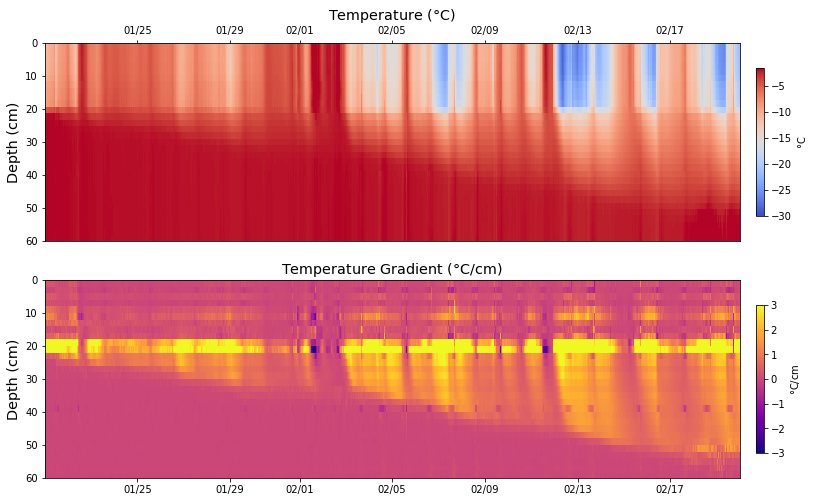

In [5]:
grad = np.diff(array,axis=0)*2 # Multiplied by 2 because of 2cm thermistor spacing

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols = 1, figsize=(15, 8))

# Upper plot

x1 = ax1.imshow(array, aspect='auto', extent=extent, cmap='coolwarm',vmin=-30,vmax=-1.5)
ax1.set_title(r'Temperature ($\degree$C)', fontsize='x-large')
ax1.xaxis.tick_top()

# Lower plot

x2 = ax2.imshow(grad, aspect='auto', extent=extent, cmap='plasma',vmin=-3,vmax=3)
ax2.set_title(r'Temperature Gradient ($\degree$C/cm)', fontsize='x-large')
ax1.xaxis.tick_top()

# Set x axis to datetime

for ax in [ax1,ax2]:
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_format)
    y_lims = (30,0)
    ax.set_yticks(range(0,31,5))
    ax.set_yticklabels(range(0,61,10))
    ax.set_ylabel('Depth (cm)', fontsize='x-large')

# Make colorbars

plt.colorbar(x1,ax=ax1,shrink=0.75, label = r'$\degree$C', pad= 0.02)
plt.colorbar(x2,ax=ax2,shrink=0.75, label = r'$\degree$C/cm', pad= 0.02)

# Visualise

# plt.show()

# Looking at the temperature gradient is pretty useful! We can see that in fost the vast majority of the time, the heat flows out of the ice into the atmosphere.

# But the direction of this flow occasionally inverts, and heat flows into the ice from the air. This is noticeable between from 1st - 3rd Feb and on 11th Feb.

# Let's look at this in a bit more detail...

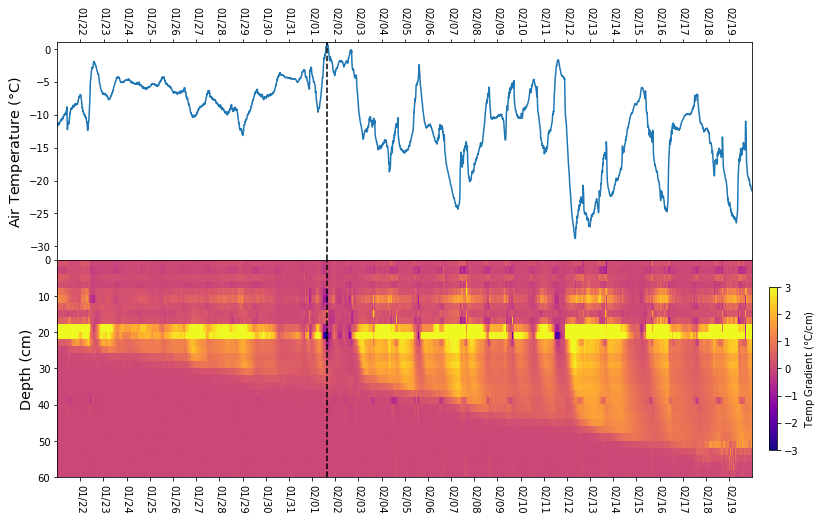

In [6]:
fig = plt.figure(figsize=(15, 8))

# Make a gridspec to line up the figs

widths = [1.05,0.1]
gs = fig.add_gridspec(ncols=2,nrows=2,width_ratios=widths)

# Upper plot

ax1 = fig.add_subplot(gs[0,0])

x1 = ax1.plot(dat.index, array[0])

ax1.set_xlim(dat.index[0],dat.index[-1])
ax1.tick_params('x',rotation=270)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis_date()
date_format = mdates.DateFormatter('%m/%d')
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.tick_top()
ax1.set_ylim(-32,1)
ax1.set_ylabel(r'Air Temperature ($\degree$C)', fontsize='x-large')

# Lower plot

ax2 = fig.add_subplot(gs[1,:])

# Make plot

x2 = ax2.imshow(grad, aspect='auto', cmap='plasma',vmin=-3,vmax=3, extent=extent)

# Time axis

ax2.xaxis_date()
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.tick_params('x',rotation=270)


# Y axis

ax2.set_yticks(range(0,31,5))
ax2.set_yticklabels(range(0,61,10))
ax2.set_ylabel('Depth (cm)', fontsize='x-large')

# Make vertical line to indicate an instance of reversed heat flow

for ax in [ax1,ax2]:
    ax.axvline(737456.65,color='k',ls='--') # This is hacky garbage

# Make colorbars

plt.colorbar(x2,ax=ax2,shrink=0.75, label = r'Temp Gradient ($\degree$C/cm)', pad= 0.02)

plt.subplots_adjust(hspace=0)

# Visualise

plt.show()

# But what's that bright layer at the top of the ice? 

# My first guess was snow, but it's clearly present since the 21st of Jan. Send me your thoughts!

# It turns out that this is *above* the snow/ice surface, and is perhaps a stable, cold boundary layer that exists in the few centimeters above the surface. Does the concrete wall of the pool protect this area from wind?

In [7]:
start_date = datetime.datetime(year=2020,month=1,day=25)
end_date = datetime.datetime(year=2020,month=2,day=12)

dat_ = dat.loc[(end_date >= dat.index) & (dat.index >= start_date)].copy()

cols_to_drop = [col for col in dat_.columns if col[:4] != 'Temp']
        
dat_.drop(columns=cols_to_drop,inplace=True)

temps = dat_.to_numpy(dtype=float)

date_index = [x.strftime("%d/%m/%y, \n%H:%M") for x in dat_.index]

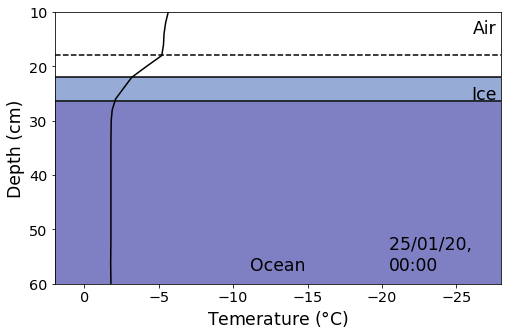

In [8]:
ice_bottom = detect_base2(temps,smoothe=True)['base']

fig, ax = plt.subplots(figsize=(8,5))

plt.xticks(fontsize='x-large')

ax.set_yticks(range(5,31,5))
ax.set_yticklabels(range(10,61,10),fontsize='x-large')

ax.set_ylabel('Depth (cm)',fontsize='xx-large')
ax.set_xlabel(r'Temerature ($\degree$C)',fontsize='xx-large')

ax.set_xlim([2,-28])
ax.set_ylim([30,5])

lines = ax.plot([],color='k')
line_p = lines[0]

annotation = ax.annotate('', xy=(0.75,0.05), # This is the date/time annotation
                         xycoords='axes fraction',
                         fontsize='xx-large',
                         color='k')

m_annotation = ax.annotate('Air', xy=(0.99,0.92),
                         xycoords='axes fraction',
                         fontsize='xx-large',
                         ha='right',
                         color='k')

m_annotation = ax.annotate('Ice', xy=(0.99,0.68),
                         xycoords='axes fraction',
                         fontsize='xx-large',
                         ha='right',
                         color='k')

m_annotation = ax.annotate('Ocean', xy=(0.5,0.05),
                         xycoords='axes fraction',
                         fontsize='xx-large',
                         ha='center',
                         color='k')
                         
annotation.set_animated(True)

ice_base = plt.axhline(y=0,color='k')
ice_surface = plt.axhline(y=11,color='k')
boundary_layer_top = plt.axhline(y=9,color='k',ls='--')


rect = ax.axhspan(11,35,alpha=0.5,color='darkblue')

rect = ax.axhspan(11,15,alpha=0.5,color='lightblue')

def animate(frame):
    
    line_p.set_data(temps[frame], range(len(temps[frame])))
    
    annotation.set_text(date_index[frame])
    
    if not np.isnan(ice_bottom[frame]):
    
        ice_base.set_ydata(ice_bottom[frame]+1)
        
        rect.set_xy([[ 0,  11],
                       [ 0, ice_bottom[frame]+1],
                       [ 1, ice_bottom[frame]+1],
                       [ 1,  11],
                       [ 0,  11]])
    
    return line_p, annotation, ice_base, rect

ani = animation.FuncAnimation(fig, animate,
#                               frames = range(100),
                              frames= temps.shape[0],
                              interval=18)    

# Preview animation inside the notebook

In [9]:
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Save the animation as a .gif

In [10]:
# Writer = animation.writers['imagemagick']
# writer = Writer(fps=10, metadata=dict(artist='Robbie Mallett CPOM UCL'))
# ani.save('SERF_thermistor.gif', writer=writer)

# Save the animation as a .mp4

In [11]:
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Robbie Mallett CPOM UCL'))
# ani.save('SERF_thermistor.mp4', writer=writer)